In [1]:
!wget https://github.com/imguru-mooc/AI_VISION/raw/main/4_day/2.SSD/2.SSD.zip

--2023-10-19 05:02:25--  https://github.com/imguru-mooc/AI_VISION/raw/main/4_day/2.SSD/2.SSD.zip
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/imguru-mooc/AI_VISION/main/4_day/2.SSD/2.SSD.zip [following]
--2023-10-19 05:02:26--  https://raw.githubusercontent.com/imguru-mooc/AI_VISION/main/4_day/2.SSD/2.SSD.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 422923 (413K) [application/zip]
Saving to: ‘2.SSD.zip’

2.SSD.zip           100%[===================>] 413.01K  --.-KB/s    in 0.03s   

2023-10-19 05:02:26 (13.4 MB/s) - ‘2.SSD.zip’ saved [422923/422923]



In [2]:
!unzip 2.SSD.zip

Archive:  2.SSD.zip
  inflating: calibril.ttf            
  inflating: create_data_lists.py    
  inflating: datasets.py             
  inflating: detect.py               
  inflating: eval.py                 
  inflating: model.py                
  inflating: train.py                
  inflating: utils.py                


In [3]:
!gdown https://drive.google.com/uc?id=1ePhewWJQfqI43FVkgvWd-uPqHQjI9tv5

Downloading...
From: https://drive.google.com/uc?id=1ePhewWJQfqI43FVkgvWd-uPqHQjI9tv5
To: /content/checkpoint_ssd300.pth.tar
100% 105M/105M [00:00<00:00, 135MB/s]


In [4]:
!wget http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtest_06-Nov-2007.tar
!tar xf VOCtest_06-Nov-2007.tar

--2023-10-19 05:02:41--  http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtest_06-Nov-2007.tar
Resolving host.robots.ox.ac.uk (host.robots.ox.ac.uk)... 129.67.94.152
Connecting to host.robots.ox.ac.uk (host.robots.ox.ac.uk)|129.67.94.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 451020800 (430M) [application/x-tar]
Saving to: ‘VOCtest_06-Nov-2007.tar’

VOCtest_06-Nov-2007 100%[===================>] 430.13M  25.5MB/s    in 18s     

2023-10-19 05:02:59 (24.5 MB/s) - ‘VOCtest_06-Nov-2007.tar’ saved [451020800/451020800]



In [7]:
from IPython.display import display
from torchvision import transforms
from utils import *
from PIL import Image, ImageDraw, ImageFont

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load model checkpoint
checkpoint = 'checkpoint_ssd300.pth.tar'
checkpoint = torch.load(checkpoint)
start_epoch = checkpoint['epoch'] + 1
print('\nLoaded checkpoint from epoch %d.\n' % start_epoch)
model = checkpoint['model']
model = model.to(device)
model.eval()

# Transforms
resize = transforms.Resize((300, 300))
to_tensor = transforms.ToTensor()
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])


Loaded checkpoint from epoch 232.



In [9]:
def detect(original_image, min_score, max_overlap, top_k, suppress=None):
    """
    Detect objects in an image with a trained SSD300, and visualize the results.

    :param original_image: image, a PIL Image
    :param min_score: minimum threshold for a detected box to be considered a match for a certain class
    :param max_overlap: maximum overlap two boxes can have so that the one with the lower score is not suppressed via Non-Maximum Suppression (NMS)
    :param top_k: if there are a lot of resulting detection across all classes, keep only the top 'k'
    :param suppress: classes that you know for sure cannot be in the image or you do not want in the image, a list
    :return: annotated image, a PIL Image
    """

    # Transform
    image = normalize(to_tensor(resize(original_image)))

    # Move to default device
    image = image.to(device)

    # Forward prop.
    predicted_locs, predicted_scores = model(image.unsqueeze(0))

    # Detect objects in SSD output
    det_boxes, det_labels, det_scores = model.detect_objects(predicted_locs, predicted_scores, min_score=min_score,
                                                             max_overlap=max_overlap, top_k=top_k)

    # Move detections to the CPU
    det_boxes = det_boxes[0].to('cpu')

    # Transform to original image dimensions
    original_dims = torch.FloatTensor(
        [original_image.width, original_image.height, original_image.width, original_image.height]).unsqueeze(0)
    det_boxes = det_boxes * original_dims

    # Decode class integer labels
    det_labels = [rev_label_map[l] for l in det_labels[0].to('cpu').tolist()]

    # If no objects found, the detected labels will be set to ['0.'], i.e. ['background'] in SSD300.detect_objects() in model.py
    if det_labels == ['background']:
        # Just return original image
        return original_image

    # Annotate
    annotated_image = original_image
    draw = ImageDraw.Draw(annotated_image)
    font = ImageFont.truetype("./calibril.ttf", 15)

    # Suppress specific classes, if needed
    for i in range(det_boxes.size(0)):
        if suppress is not None:
            if det_labels[i] in suppress:
                continue

        # Boxes
        box_location = det_boxes[i].tolist()
        draw.rectangle(xy=box_location, outline=label_color_map[det_labels[i]])
        draw.rectangle(xy=[l + 1. for l in box_location], outline=label_color_map[
            det_labels[i]])  # a second rectangle at an offset of 1 pixel to increase line thickness
        # draw.rectangle(xy=[l + 2. for l in box_location], outline=label_color_map[
        #     det_labels[i]])  # a third rectangle at an offset of 1 pixel to increase line thickness
        # draw.rectangle(xy=[l + 3. for l in box_location], outline=label_color_map[
        #     det_labels[i]])  # a fourth rectangle at an offset of 1 pixel to increase line thickness

        # Text
        text_size = font.getsize(det_labels[i].upper())
        # print(text_size)
        # text_size = font.getbbox (det_labels[i].upper())
        text_location = [box_location[0] + 2., box_location[1] - text_size[1]]
        textbox_location = [box_location[0], box_location[1] - text_size[1], box_location[0] + text_size[0] + 4.,
                            box_location[1]]
        draw.rectangle(xy=textbox_location, fill=label_color_map[det_labels[i]])
        draw.text(xy=text_location, text=det_labels[i].upper(), fill='white',
                  font=font)
    del draw

    return annotated_image




<ipython-input-9-d41f0ce30795>:64: DeprecationWarning: getsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use getbbox or getlength instead.
  text_size = font.getsize(det_labels[i].upper())


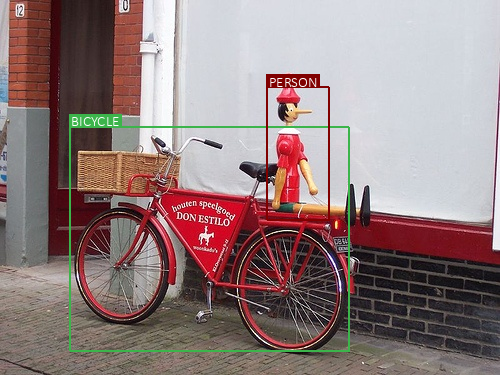

In [16]:
if __name__ == '__main__':
    img_path = '/content/VOCdevkit/VOC2007/JPEGImages/000015.jpg'
    original_image = Image.open(img_path, mode='r')
    original_image = original_image.convert('RGB')
    annotated_image = detect(original_image, min_score=0.2, max_overlap=0.5, top_k=200)

    display(annotated_image)